# Análise de perfis de clientes: aplicando o Support Vector Classifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_validate, KFold

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# 1. Importando o dataset

In [ ]:
df_g = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/santander-coders-2023/projetos/ml2/dataset_cluster.csv")

In [ ]:
df_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2212 non-null   int64  
 1   Year_Birth           2212 non-null   int64  
 2   Education            2212 non-null   object 
 3   Income               2212 non-null   float64
 4   Kidhome              2212 non-null   int64  
 5   Teenhome             2212 non-null   int64  
 6   Dt_Customer          2212 non-null   object 
 7   Recency              2212 non-null   int64  
 8   MntWines             2212 non-null   int64  
 9   MntFruits            2212 non-null   int64  
 10  MntMeatProducts      2212 non-null   int64  
 11  MntFishProducts      2212 non-null   int64  
 12  MntSweetProducts     2212 non-null   int64  
 13  MntGoldProds         2212 non-null   int64  
 14  NumDealsPurchases    2212 non-null   int64  
 15  NumWebPurchases      2212 non-null   i

In [ ]:
# Eliminando a coluna de data de cadastro do cliente
df_g = df_g.drop(columns=["Dt_Customer"])

# Eliminando a coluna de cluster duplicada
df_g = df_g.drop(columns=["cluster"])

Notamos ainda a presença de 3 colunas com valores categóricos.

In [ ]:
cat_columns = df_g.select_dtypes(include=["object"]).columns.values
cat_columns

array(['Education', 'Partner', 'Age_Category'], dtype=object)

In [ ]:
for c in cat_columns:
  print(f"{c}: {df_g[c].unique()}")

Education: ['Graduated' 'Post Graduated' 'Not Graduated']
Partner: ['Not Partner' 'Partner']
Age_Category: ['Elderly' 'Adult' 'Young']


Transformando as colunas categóricas em numéricas:

In [ ]:
df_g = pd.get_dummies(df_g, columns = cat_columns, prefix = cat_columns)

Verificando a correlação das nossas features com a coluna de cluster:

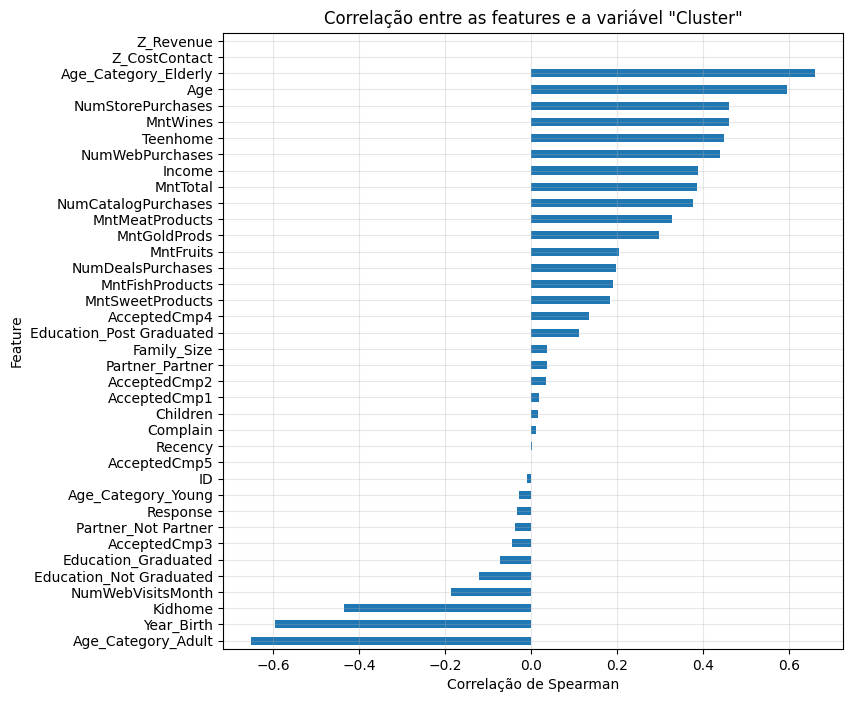

In [ ]:
corr_matrix = df_g.corr(method = 'spearman')

# Selecionando as correlações da variável "Cluster":
correlations = corr_matrix["Cluster"].drop("Cluster")
correlations.sort_values(ascending=True, inplace=True)

# Plotando:
plt.figure(figsize=(8,8))
correlations.plot(kind="barh")
plt.xlabel("Correlação de Spearman")
plt.ylabel("Feature")
plt.title("Correlação entre as features e a variável \"Cluster\"")
plt.grid(alpha=0.3)

Observamos a falta de correlação nas colunas `Z_Revenue`, `Z_CostContact` e `Complain`. Vamos dropa-las.

In [ ]:
df_g.drop(columns=["Complain", "Z_CostContact", "Z_Revenue"], inplace=True)

Finalmente, conferindo a distribuição do nosso target `Cluster` no dataset, que caracteriza o perfil dos nossos clientes:

0    0.370253
1    0.222423
3    0.219711
2    0.187613
Name: Cluster, dtype: float64


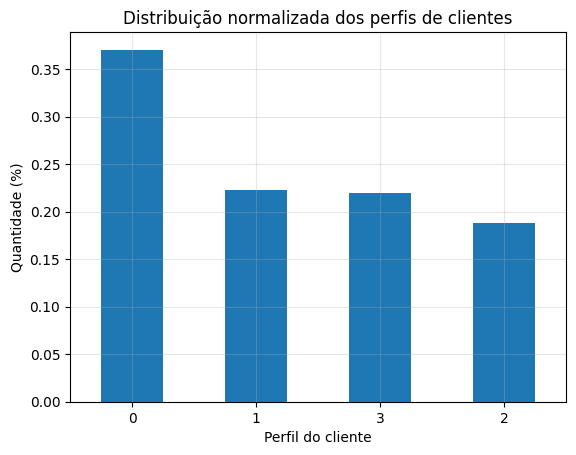

In [ ]:
dist_perfis = df_g["Cluster"].value_counts(normalize=True)
dist_perfis.plot(kind="bar")
plt.xlabel("Perfil do cliente")
plt.ylabel("Quantidade (%)")
plt.title("Distribuição normalizada dos perfis de clientes")
plt.xticks(rotation=0)
plt.grid(alpha=0.3)
print(dist_perfis)

# 2. Support Vector Classifier

## 2.1. Teste inicial

In [ ]:
# Definindo uma função para plotarmos nossos parâmetros de avaliação:

def print_avaliacao(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plot_confusion_matrix(conf_mat = cm, show_normed = True)

  print(classification_report(y_test, y_pred))

  return pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

Primeiramente, vamos rodar o modelo com seus valores default.

In [ ]:
# Definindo as features e o target:

X = df_g.drop(columns=["Cluster"])
y = df_g["Cluster"]

# Separando os dados tem treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

# Normalizando
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [ ]:
%%time

# Aplicando o modelo:
svc = SVC()
svc.fit(X_train_norm, y_train)

CPU times: user 62.3 ms, sys: 44 µs, total: 62.3 ms
Wall time: 67.4 ms


SVC()

Verificando o desempenho do modelo **nos dados de treino**:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       573
           1       0.98      0.98      0.98       344
           2       0.99      0.92      0.95       291
           3       0.98      0.99      0.99       340

    accuracy                           0.98      1548
   macro avg       0.98      0.97      0.98      1548
weighted avg       0.98      0.98      0.98      1548



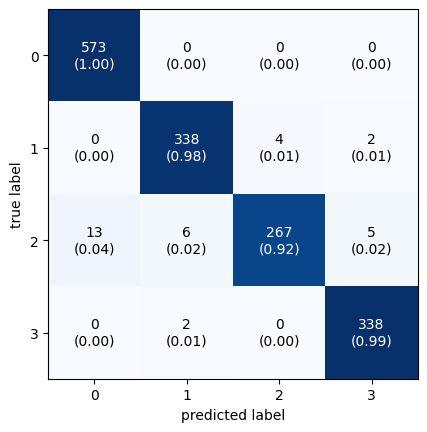

In [ ]:
# Predict (treino)
y_pred_train = svc.predict(X_train_norm)

# Avaliação
df_svc_inicial_treino = print_avaliacao(y_train, y_pred_train)

 Um bom desempenho no conjunto de treino é encorajador, mas é crucial verificar se o modelo generaliza bem para dados não vistos (conjunto de teste). Se o modelo tiver um desempenho significativamente pior no conjunto de teste, isso pode ser um sinal de overfitting.

Verificando o desempenho do modelo **nos dados de teste**:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       246
           1       0.95      0.97      0.96       148
           2       0.97      0.89      0.93       124
           3       0.97      0.97      0.97       146

    accuracy                           0.96       664
   macro avg       0.96      0.96      0.96       664
weighted avg       0.96      0.96      0.96       664



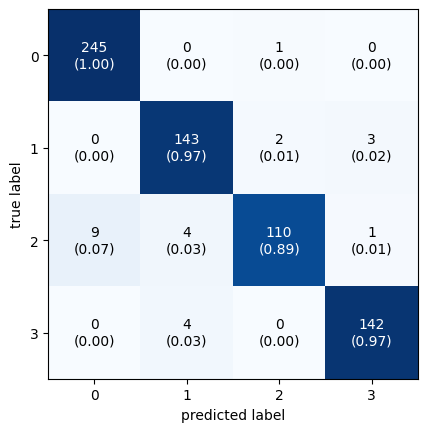

In [ ]:
# Predict (teste)
y_pred_test = svc.predict(X_test_norm)

# Avaliação
df_svc_inicial_teste = print_avaliacao(y_test, y_pred_test)

**Interpretando os resultados obtidos nos dados de teste:**

* **Precisão (Precision):** A precisão indica a proporção de identificações positivas que foram realmente corretas. Por exemplo, para a classe 0, uma precisão de 0.96 significa que 96% das previsões da classe 0 pelo modelo estavam corretas.
* **Recall:** O recall indica a proporção de casos positivos reais que foram identificados corretamente. Por exemplo, para a classe 0, um recall de 1.00 significa que o modelo identificou corretamente 100% de todos os casos reais da classe 0.
F1-Score:
* O **F1-score** é a média harmônica de precisão e recall, fornecendo um equilíbrio entre essas duas métricas. Valores altos de F1-score indicam um bom equilíbrio entre precisão e recall. Por exemplo, o F1-score de 0.98 para a classe 0 é excelente.
* **Acurácia (Accuracy):** A acurácia global do modelo é de 0.96, o que significa que 96% das previsões estavam corretas.
* **Suporte (Support):** O suporte indica o número de ocorrências reais da classe no conjunto de dados especificado. Isso ajuda a entender o quão representativa é a métrica para cada classe.
* **Médias Macro e Ponderada:** A média macro calcula a média das métricas, dando igual peso a cada classe, o que é útil em situações onde você se preocupa igualmente com todas as classes. A média ponderada leva em conta o suporte de cada classe, sendo mais representativa quando há desbalanceamento entre as classes. Nesse caso, obtivemos um desempenho de 96% para todos os casos, o que demonstra um ótimo resultado.

**Comparando com os resultados de treino:**

* **Consistência com o Conjunto de Treino:** Os resultados no conjunto de teste são consistentes com o desempenho no conjunto de treino, indicando que o modelo generaliza bem e não está sofrendo de overfitting significativo.

* **Desempenho por Classe:** O modelo parece ter um bom desempenho em todas as classes, com ligeiras variações. Por exemplo, **a classe 2 tem um recall ligeiramente menor em comparação com as outras classes, o que pode indicar uma dificuldade maior do modelo em identificar corretamente todos os casos dessa classe**.

In [ ]:
def plot_comparacao_metricas(metrica1, metrica2, label):
  x = np.arange(4)
  width = 0.35
  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, metrica1, width, label=label[0])
  rects2 = ax.bar(x + width/2, metrica2, width, label=label[1])
  ax.set_ylabel('Valores')
  ax.set_title(f'Comparação entre {label[0]} e {label[1]}')
  ax.set_xticks(x)
  ax.set_xticklabels(x)
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.grid(alpha=0.3)
  plt.show()

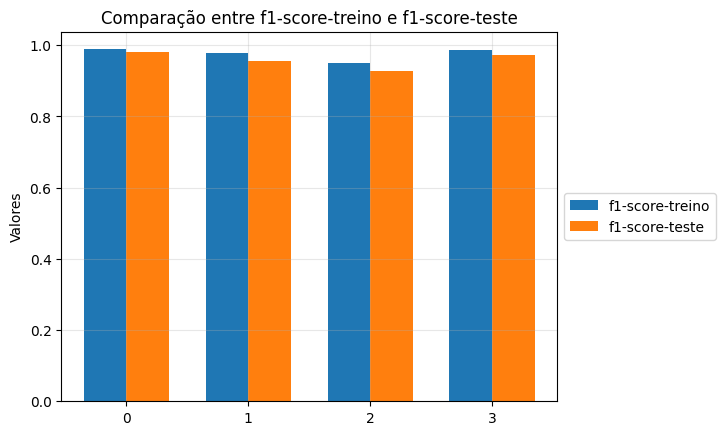

In [ ]:
plot_comparacao_metricas(df_svc_inicial_treino.iloc[2][:4],
                         df_svc_inicial_teste.iloc[2][:4],
                         label = ["f1-score-treino", "f1-score-teste"])

In [ ]:
df_svc_inicial_teste

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.964567,0.947020,0.973451,0.972603,0.963855,0.964410,0.964082
recall,0.995935,0.966216,0.887097,0.972603,0.963855,0.955463,0.963855
f1-score,0.980000,0.956522,0.928270,0.972603,0.963855,0.959349,0.963480
support,246.000000,148.000000,124.000000,146.000000,0.963855,664.000000,664.000000


## 2.2. Grid Search

In [ ]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Os parâmetros que escolhemos para testagem foram:
* `C`: parâmetro de regularização, relacionado com a "suavidade" da margem.
* `gamma`: define a influência que cada ponto tem na fronteira de decisão. É a "abertura" do kernel: quanto **maior** o gamma, a influência é de mais curto alcance, e vice-versa.
* `kernel`: com as opções disponíveis sendo `linear`, `poly`, `rbf` e `sigmoid`.

In [ ]:
# Definição da estrutura de validação cruzada:
splitter = KFold(n_splits = 7, shuffle = True, random_state = 42)

# Definição da métrica de avaliação do estimador:
metrica = "f1_weighted"
# Vamos considerar o pequeno desbalanceamento das classes.

# Parâmetros que buscamos melhorar:
param_grid_svc = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "C": np.logspace(-2,2,7),
    "gamma": np.logspace(-2,2,7)
}

# Definição do estimador
svc_grid = SVC()

# Grid search:
grid_svc = GridSearchCV(estimator = svc_grid,
                        param_grid = param_grid_svc,
                        scoring = metrica,
                        cv = splitter,
                        verbose = 10,
                        n_jobs = -1)

In [ ]:
grid_svc

GridSearchCV(cv=KFold(n_splits=7, random_state=42, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 4.64158883e-02, 2.15443469e-01, 1.00000000e+00,
       4.64158883e+00, 2.15443469e+01, 1.00000000e+02]),
                         'gamma': array([1.00000000e-02, 4.64158883e-02, 2.15443469e-01, 1.00000000e+00,
       4.64158883e+00, 2.15443469e+01, 1.00000000e+02]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1_weighted', verbose=10)

In [ ]:
%%time
# Aplicação do processo do GridSearch:
grid_svc.fit(X_train_norm, y_train)

Fitting 7 folds for each of 196 candidates, totalling 1372 fits
CPU times: user 3.8 s, sys: 463 ms, total: 4.27 s
Wall time: 2min 25s


GridSearchCV(cv=KFold(n_splits=7, random_state=42, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 4.64158883e-02, 2.15443469e-01, 1.00000000e+00,
       4.64158883e+00, 2.15443469e+01, 1.00000000e+02]),
                         'gamma': array([1.00000000e-02, 4.64158883e-02, 2.15443469e-01, 1.00000000e+00,
       4.64158883e+00, 2.15443469e+01, 1.00000000e+02]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1_weighted', verbose=10)

In [ ]:
grid_svc.best_params_

{'C': 100.0, 'gamma': 0.01, 'kernel': 'linear'}

Rodando com esses valores:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       246
           1       0.99      0.97      0.98       148
           2       0.92      0.97      0.94       124
           3       0.98      0.98      0.98       146

    accuracy                           0.97       664
   macro avg       0.97      0.97      0.97       664
weighted avg       0.97      0.97      0.97       664



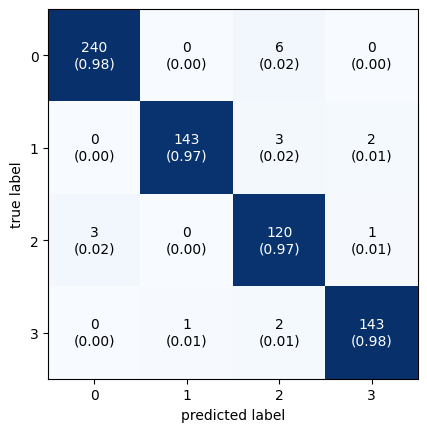

In [ ]:
best_svc = SVC(C = grid_svc.best_params_["C"],
               gamma = grid_svc.best_params_["gamma"],
               kernel = grid_svc.best_params_["kernel"])

best_svc.fit(X_train_norm, y_train)

# Predict (teste)
y_pred = best_svc.predict(X_test_norm)

# Avaliação
df_svc_grid_teste = print_avaliacao(y_test, y_pred)

## 2.3. Comparando os resultados de teste (inicial vs. parâmetros obtidos do Grid Search)

Os resultados obtidos com o modelo SVC após a otimização dos parâmetros via Grid Search mostram um desempenho muito bom e uma leve melhoria em comparação com os resultados de teste obtidos anteriormente.

In [ ]:
df_svc_inicial_teste

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.964567,0.947020,0.973451,0.972603,0.963855,0.964410,0.964082
recall,0.995935,0.966216,0.887097,0.972603,0.963855,0.955463,0.963855
f1-score,0.980000,0.956522,0.928270,0.972603,0.963855,0.959349,0.963480
support,246.000000,148.000000,124.000000,146.000000,0.963855,664.000000,664.000000


In [ ]:
df_svc_grid_teste

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.987654,0.993056,0.916031,0.979452,0.972892,0.969048,0.973679
recall,0.975610,0.966216,0.967742,0.979452,0.972892,0.972255,0.972892
f1-score,0.981595,0.979452,0.941176,0.979452,0.972892,0.970419,0.973098
support,246.000000,148.000000,124.000000,146.000000,0.972892,664.000000,664.000000


* **Precisão:** A precisão variava de 0.95 a 0.97 para as diferentes classes. Depois, a precisão aumentou ligeiramente, com valores entre 0.92 e 0.99.

* **Recall:** Antes, o recall variava de 0.89 a 1.00. Depois, aumentou para a maioria das classes, com a classe 2 mostrando uma melhoria significativa de 0.89 para 0.97.

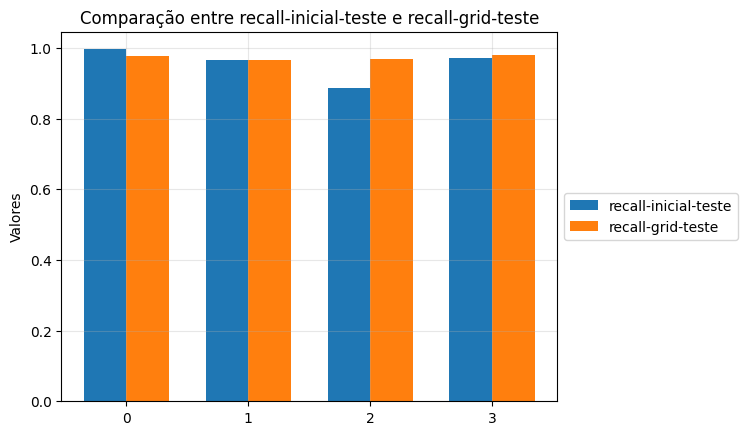

In [ ]:
plot_comparacao_metricas(df_svc_inicial_teste.iloc[1][:4],
                         df_svc_grid_teste.iloc[1][:4],
                         label = ["recall-inicial-teste", "recall-grid-teste"])

* **F1-Score:** Antes, os F1-scores variavam de 0.93 a 0.98. Depois, passaram a variar de 0.94 a 0.98, indicando um equilíbrio ligeiramente melhor entre precisão e recall, especialmente para a classe 2.

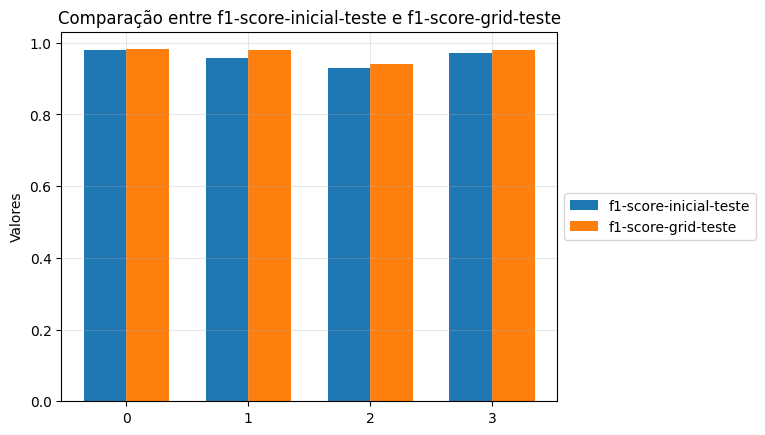

In [ ]:
plot_comparacao_metricas(df_svc_inicial_teste.iloc[2][:4],
                         df_svc_grid_teste.iloc[2][:4],
                         label = ["f1-score-inicial-teste", "f1-score-grid-teste"])

* **Acurácia Geral:** Antes, a acurácia era de 0.96. Depois, aumentou para 0.97.

* **Médias Macro e Ponderada:** Ambas as médias macro e ponderada mostram uma melhoria, indicando um aumento geral no desempenho do modelo, apesar de pouco significativo.

# 3. Conclusão

A aplicação do Grid Search com validação cruzada ajudou a encontrar uma combinação de hiperparâmetros que melhorou o desempenho do modelo em todas as métricas consideradas (precisão, recall e F1-score), bem como a acurácia geral.

* A melhoria no F1-score, especialmente para a classe 2, sugere um melhor equilíbrio entre precisão e recall, o que é essencial em muitas aplicações práticas.

* O modelo otimizado mostra um desempenho consistente e elevado em todas as classes, o que é importante em cenários de classificação multiclasse.

**Conclusão:** o uso do Grid Search resultou em uma otimização efetiva dos hiperparâmetros do SVC, levando a uma melhoria no desempenho em relação ao conjunto de teste. Isso demonstra a importância de uma seleção cuidadosa e ajuste de hiperparâmetros em modelos de aprendizado de máquina.

**Limitações:** o fato de se tratar de um dataset fictício, que apresentou um ótimo desempenho para uma clusterização de 4 classes, nos indica que essa pode ter sido a intenção inicial de seus autores. Dessa forma, os dados foram provavelmente direcionados de forma proposital para se encaixarem nesses perfis, enviezando nosso modelo de predição, o que implicou na obtenção de ótimas métricas de avaliação. Reconhecemos que esse cenário ideal está longe da realidade.